In [1]:
# Import modules
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

# Plot configurations
%matplotlib inline

# Notebook auto reloads code.
%load_ext autoreload
%autoreload 2

# NeuroTorch Tutorial

**NeuroTorch** is a framework for reconstructing neuronal morphology from
optical microscopy images. It interfaces PyTorch with different
automated neuron tracing algorithms for fast, accurate, scalable
neuronal reconstructions. It uses deep learning to generate an initial
segmentation of neurons in optical microscopy images. This
segmentation is then traced using various automated neuron tracing
algorithms to convert the segmentation into an SWC file—the most
common neuronal morphology file format. NeuroTorch is designed with
scalability in mind and can handle teravoxel-sized images.

This IPython notebook will outline a brief tutorial for using NeuroTorch
to train and predict on image volume datasets.

## Creating image datasets

One of NeuroTorch’s key features is its dynamic approach to volumetric datasets, which allows it to handle teravoxel-sized images without worrying about memory concerns and efficiency. Everything is loaded just-in-time based on when it is needed or expected to be needed. To load an image dataset, we need
to specify the voxel coordinates of each image file as shown in files `inputs_spec.json` and `labels_spec.json`.

### `inputs_spec.json`

```json
[
    {
	"filename" : "inputs.tif",
	"bounding_box" : [[0, 0, 0], [1024, 512, 50]]
    },
    {
	"filename" : "inputs.tif",
	"bounding_box" : [[0, 0, 50], [1024, 512, 100]]
    }
]

```

### `labels_spec.json`

```json
[
    {
	"filename" : "labels.tif",
	"bounding_box" : [[0, 0, 0], [1024, 512, 50]]
    },
    {
	"filename" : "labels.tif",
	"bounding_box" : [[0, 0, 50], [1024, 512, 100]]
    }
]
```

## Loading image datasets

Now that the image datasets for the inputs and labels have been specified,
these datasets can be loaded with NeuroTorch.

In [3]:
from neurotorch.datasets.specification import JsonSpec
import os

IMAGE_PATH = '../../tests/images/'

json_spec = JsonSpec() # Initialize the JSON specification

# Create a dataset containing the inputs
inputs = json_spec.open(os.path.join(IMAGE_PATH,
                                     "inputs_spec.json")) 

# Create a dataset containing the labels
labels = json_spec.open(os.path.join(IMAGE_PATH,
                                     "labels_spec.json"))


## Training with the image datasets

To train a neural network using these image datasets, load the 
neural network architecture and initialize a `Trainer`. To save
training checkpoints, add a `CheckpointWriter` to the `Trainer` object.
Lastly, call the `Trainer` object to run training.

In [ ]:
from neurotorch.core.trainer import Trainer
from neurotorch.nets.RSUNet import RSUNet
from neurotorch.training.checkpoint import CheckpointWriter

net = RSUNet() # Initialize the U-Net architecture

# Setup the trainer
trainer = Trainer(net, inputs, labels, max_epochs=1000,
                  gpu_device=0)

# Setup the trainer the add a checkpoint every 500 epochs
trainer = CheckpointWriter(trainer, checkpoint_dir='.',
                           checkpoint_period=500)

trainer.run_training()


## Predicting using NeuroTorch

Once training has completed, we can use the training checkpoints
to predict on image datasets. We first have to 
load the neural network architecture and image volume.
We then have to initialize a `Predictor` object and an output volume.
Once these have been specified, we can begin prediction.

In [ ]:
from neurotorch.nets.RSUNet import RSUNet
from neurotorch.core.predictor import Predictor
from neurotorch.datasets.filetypes import TiffVolume
from neurotorch.datasets.dataset import Array
from neurotorch.datasets.datatypes import (BoundingBox, Vector)
import numpy as np
import tifffile as tif
import os

IMAGE_PATH = '../../tests/images/'

net = RSUNet() # Initialize the U-Net architecture

checkpoint = './iteration_1000.ckpt' # Specify the checkpoint path

with TiffVolume(os.path.join(IMAGE_PATH,
                             "inputs.tif"),
                BoundingBox(Vector(0, 0, 0),
                            Vector(1024, 512, 50))) as inputs:
    predictor = Predictor(net, checkpoint, gpu_device=0)

    output_volume = Array(np.zeros(inputs.getBoundingBox()
                                   .getNumpyDim(), dtype=np.float32))

    predictor.run(inputs, output_volume, batch_size=5)

    tif.imsave("test_prediction.tif",
               output_volume.getArray().astype(np.float32))



## Displaying the prediction

Predictions are output in logits form. To map this to a
probability distribution, we need to apply a sigmoid function
to the prediction. We can then evaluate the prediction and 
ground-truth.

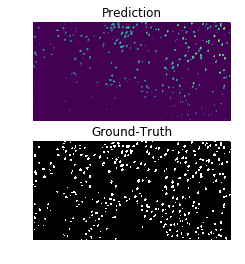

In [33]:
# Apply sigmoid function
probability_map = 1/(1+np.exp(-output_volume.getArray()))

# Plot prediction and ground-truth
plt.subplot(2, 1, 1)
plt.title('Prediction')
plt.imshow(output_volume.getArray()[25])
plt.axis('off')

plt.subplot(2, 1, 2)
plt.title('Ground-Truth')
plt.imshow(labels.get(
    BoundingBox(Vector(0, 0, 0),
                Vector(1024, 512, 50))).getArray()[25],
           cmap='gray'
          )
plt.axis('off')

plt.show()